# LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# UTILS

In [2]:
def extract_from_catalogues(samples,path,real_signatures=5,runs=10):
    
    all_detected={}
    all_mse={}
    all_stability={}
    all_min_stability={}

    for sample in samples:    
        detected_sigs=[]
        mses=[]
        mean_stability=[]
        min_stability=[]
        
        for num in range(1,runs+1):
            
            denovo_sig=pd.read_csv(path+str(num)+'_'+str(sample)+'/SBS96/Suggested_Solution/SBS96_De-Novo_Solution/Signatures/SBS96_De-Novo_Signatures.txt',sep='\t')
            denovo_exp=pd.read_csv(path+str(num)+'_'+str(sample)+'/SBS96/Suggested_Solution/SBS96_De-Novo_Solution/Activities/SBS96_De-Novo_Activities_refit.txt',sep='\t')
            real_cat=pd.read_csv(path+str(num)+'_'+str(sample)+'/SBS96/Samples.txt',sep='\t')
            pred_cat=pd.DataFrame(denovo_sig.iloc[:,1:].values @ denovo_exp.iloc[:,1:].T.values)
            pred_cat.insert(0,'Mutation Types',real_cat['Mutation Types'])
            pred_cat.columns=real_cat.columns
            
            detected_sig=denovo_sig.iloc[:,1:].shape[1]
            mean_stability.append(np.mean(pd.read_csv(path+str(num)+'_'+str(sample)+'/SBS96/All_Solutions/SBS96_'+str(detected_sig)+'_Signatures/Solution_Stats/SBS96_S'+str(detected_sig)+'_Signatures_stats.txt',sep='\t')['Stability']))
            min_stability.append(np.min(pd.read_csv(path+str(num)+'_'+str(sample)+'/SBS96/All_Solutions/SBS96_'+str(detected_sig)+'_Signatures/Solution_Stats/SBS96_S'+str(detected_sig)+'_Signatures_stats.txt',sep='\t')['Stability']))       
            mse_tot=np.mean(np.mean(np.square(real_cat.iloc[:,1:] - pred_cat.iloc[:,1:]),axis=None))
            detected_sigs.append(detected_sig)
            mses.append(mse_tot)
            
        all_detected[str(sample)]=detected_sigs
        all_mse[str(sample)]=mses
        all_stability[str(sample)]=mean_stability
        all_min_stability[str(sample)]=min_stability
    
    # mse
    mse=pd.DataFrame(all_mse)
    mse_df=pd.DataFrame(pd.concat([mse[str(sample)] for sample in samples]))
    mse_df.index=sorted(samples*runs)
    mse_df.reset_index(inplace=True)
    mse_df.columns=['Samples','MSE']
    
    #detected signatures
    detected_df=pd.DataFrame(all_detected)
    detected_df=pd.DataFrame(pd.concat([detected_df[str(sample)] for sample in samples]))
    detected_df.index=sorted(samples*runs)
    detected_df.reset_index(inplace=True)
    detected_df['N° of true Signatures']=real_signatures
    detected_df.columns=['Samples','N° of detected Signatures','N° of true Signatures']
    
    # mean stability
    stability=pd.DataFrame(all_stability)
    stability_df=pd.DataFrame(pd.concat([stability[str(sample)] for sample in samples]))
    stability_df.index=sorted(samples*runs)
    stability_df.reset_index(inplace=True)
    stability_df.columns=['Samples','Mean Stability']
    
    # min stability 
    min_stability=pd.DataFrame(all_min_stability)
    min_stability_df=pd.DataFrame(pd.concat([min_stability[str(sample)] for sample in samples]))
    min_stability_df.index=sorted(samples*runs)
    min_stability_df.reset_index(inplace=True)
    min_stability_df.columns=['Samples','Min Stability']    
    return stability_df,min_stability_df,mse_df,detected_df


In [3]:
def statistics_results(detected_df,mse_df,stability_df,min_stability_df):
    
    # percentage
    p=pd.DataFrame(detected_df[detected_df["N° of detected Signatures"]==detected_df["N° of true Signatures"]].groupby('Samples')["N° of true Signatures"].count()/10*100).rename(columns={"N° of true Signatures":'P'})
    
    # median mse + iqr
    mse=pd.DataFrame(mse_df.groupby('Samples').MSE.apply(lambda x : np.round(np.median(x),2)))
    iqr=pd.DataFrame(mse_df.groupby('Samples').MSE.apply(lambda x: [np.round(np.percentile(x,25),2),np.round(np.percentile(x,75),2)])).rename(columns={'MSE':'IQR'}) #- np.percentile(x,[25,75])[0])).rename(columns={'MSE':'IQR'})
    mse_tot=pd.concat([mse,iqr],axis=1)
    
    # median of median stability +iqr
    stab=pd.DataFrame(stability_df.groupby('Samples')['Mean Stability'].apply(lambda x: np.round(np.median(x),2)))
    iqr_stab=pd.DataFrame(stability_df.groupby('Samples')['Mean Stability'].apply(lambda x: [np.round(np.percentile(x,25),2),np.round(np.percentile(x,75),2)])).rename(columns={'Median Stability':'IQR'})
    stability=pd.concat([stab,iqr_stab],axis=1)
    
    # median of min stability +iqr
    min_stab=pd.DataFrame(min_stability_df.groupby('Samples')['Min Stability'].apply(lambda x: np.round(np.median(x),2)))
    min_iqr_stab=pd.DataFrame(min_stability_df.groupby('Samples')['Min Stability'].apply(lambda x: [np.round(np.percentile(x,25),2),np.round(np.percentile(x,75),2)])).rename(columns={'Min Stability':'IQR'})
    min_stability=pd.concat([min_stab,min_iqr_stab],axis=1)
    
    return pd.concat([p,mse_tot,stability,min_stability],axis=1).sort_index().replace(np.nan,0)

In [4]:
def plot_extraction():

    f, axes = plt.subplots(2, 3, figsize=(18, 15), sharex=False)
    for ax, scenario in zip(axes.flat,keys):
        ax.grid()
        ax.set_yticks(np.arange(0,11))

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(12) 

        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(12) 

        ax.set_title('\n Scenario {} \n'.format(scenario))
        sns.countplot(dodge=True,x='N° of detected Signatures',hue='Samples',data=scenarios[scenarios.Scenario==scenario],ax=ax,edgecolor='black',palette='deep')
        ax.set_ylabel('N° of runs',fontsize=12)
        ax.set_xlabel('N° of detected Signatures \n',fontsize=12)

        sns.despine(left=True)

    axes.flat[2].legend(loc='upper right')
    axes.flat[4].legend(loc='upper left')

    #fig1
    patchess=axes.flat[0].patches
    width = patchess[0].get_width()
    new_width = 0.1


    patchess[0].set_width(0.1)
    patchess[0].set_label('4')
    x = patchess[0].get_x()
    patchess[0].set_x(x + (width - new_width) +.05)

    patchess[3].set_width(0.1)
    patchess[3].set_label('6')
    x = patchess[3].get_x()
    patchess[3].set_x(x + (width - 0.5) +.1)

    patchess[1].set_width(0.1)
    x = patchess[1].get_x()
    patchess[1].set_x(x + (width - 0.2) +.1)

    #fig2
    patchess=axes.flat[1].patches
    width = patchess[0].get_width()
    new_width = 0.1

    patchess[0].set_width(0.1)
    x = patchess[0].get_x()
    patchess[0].set_x(x + (width - new_width) +.05)

    patchess[3].set_width(0.1)
    x = patchess[3].get_x()
    patchess[3].set_x(x + (width - 0.5) +0.1)

    patchess[1].set_width(0.1)
    x = patchess[1].get_x()
    patchess[1].set_x(x + (width - 0.2) +0.1)

    #fig3

    patchess=axes.flat[2].patches


    for i in [30,32,33,34]:
        patchess[i].set_width(0.16)
        x = patchess[i].get_x()
        patchess[i].set_x(x-0.3)

    #fig4
    patchess=axes.flat[3].patches

    for i in [0,1,2,4]:
        patchess[i].set_width(0.35)
        x = patchess[i].get_x()
        patchess[i].set_x(x+0.22)

    patchess[-1].set_width(0.35)
    x = patchess[-1].get_x()
    patchess[-1].set_x(x-0.22)

    patchess[12].set_width(0.35)
    x = patchess[12].get_x()
    patchess[12].set_x(x)

    patchess[10].set_width(0.35)
    x = patchess[10].get_x()
    patchess[10].set_x(x)


    #fig5
    patchess=axes.flat[4].patches

    for i in [0,1,2]:
        patchess[i].set_width(0.35)
        x = patchess[i].get_x()
        patchess[i].set_x(x+0.22)
    patchess[-1].set_width(0.35)
    x = patchess[-1].get_x()
    patchess[-1].set_x(x-0.3)

    axes[-1, -1].axis('off')

    axes.flat[1].legend(title="Samples", loc="upper left") 
    axes.flat[2].legend(title="Samples", loc="upper right") 
    axes.flat[3].legend(title="Samples", loc="upper left") 
    axes.flat[4].legend(title="Samples", loc="upper left")
    
    plt.show()

In [5]:
cd /home/cpancotti/Mutational Signatures/ARCHETYPES/synthetic_sig

/home/cpancotti/Mutational Signatures/ARCHETYPES/synthetic_sig


In [6]:
COSMIC_sig=pd.read_csv('../COSMIC.csv')

## DE NOVO EXTRACTION RESULTS WITH SYNTHETIC CATALOGUES

Scenario 1

In [7]:
stability_df,min_stability_df,mse_df,detected_df=extract_from_catalogues(samples=[200,500],path='SigProfiler_experiments/five_sim_no_flat/5_sim_no_flat_',real_signatures=5,runs=10)
results=statistics_results(detected_df,mse_df,stability_df,min_stability_df)
results

,P,MSE,IQR,Mean Stability,Mean Stability,Min Stability,IQR
Samples,,,,,,,
200,90.0,27.80,"[27.65, 27.96]",0.83,"[0.83, 0.85]",0.62,"[0.58, 0.69]"
500,100.0,28.06,"[27.82, 28.54]",0.87,"[0.86, 0.89]",0.67,"[0.65, 0.74]"


Scenario 2

In [8]:
stability_df,min_stability_df,mse_df,detected_df=extract_from_catalogues(samples=[200,500],path='SigProfiler_experiments/flat_sig/flat_',real_signatures=6,runs=10)
results=statistics_results(detected_df,mse_df,stability_df,min_stability_df)
results

,P,MSE,IQR,Mean Stability,Mean Stability,Min Stability,IQR
Samples,,,,,,,
200,90.0,45.61,"[45.42, 46.28]",0.86,"[0.85, 0.89]",0.74,"[0.67, 0.8]"
500,100.0,46.64,"[46.45, 46.88]",0.93,"[0.92, 0.93]",0.85,"[0.82, 0.86]"


Scenario 3

In [9]:
stability_df,min_stability_df,mse_df,detected_df=extract_from_catalogues(samples=[200,500,1000,3000,5000],path='SigProfiler_experiments/both_sig/both_',real_signatures=11,runs=10)
results=statistics_results(detected_df,mse_df,stability_df,min_stability_df)
results

,P,MSE,IQR,Mean Stability,Mean Stability,Min Stability,IQR
Samples,,,,,,,
200,0.0,125.54,"[123.35, 127.47]",0.98,"[0.98, 0.99]",0.97,"[0.95, 0.98]"
500,0.0,129.13,"[123.59, 130.93]",0.99,"[0.98, 0.99]",0.98,"[0.96, 0.98]"
1000,0.0,127.77,"[83.91, 130.22]",0.99,"[0.81, 0.99]",0.97,"[0.57, 0.98]"
3000,0.0,59.89,"[41.23, 78.89]",0.82,"[0.82, 0.84]",0.54,"[0.49, 0.59]"
5000,30.0,41.37,"[39.6, 76.93]",0.82,"[0.8, 0.82]",0.50,"[0.34, 0.54]"


Scenario 4

In [10]:
stability_df,min_stability_df,mse_df,detected_df=extract_from_catalogues(samples=[200,500,1000],path='SigProfiler_experiments/eleven_sim_no_flat/11_sim_no_flat_',real_signatures=11,runs=10)
results=statistics_results(detected_df,mse_df,stability_df,min_stability_df)
results

,P,MSE,IQR,Mean Stability,Mean Stability,Min Stability,IQR
Samples,,,,,,,
200,0.0,101.84,"[85.66, 103.09]",0.88,"[0.85, 0.91]",0.75,"[0.62, 0.82]"
500,0.0,40.45,"[35.35, 41.02]",0.82,"[0.81, 0.84]",0.47,"[0.35, 0.48]"
1000,100.0,33.15,"[32.84, 33.35]",0.84,"[0.82, 0.84]",0.54,"[0.51, 0.57]"


Scenario 5

In [11]:
stability_df,min_stability_df,mse_df,detected_df=extract_from_catalogues(samples=[1000,3000,5000],path='SigProfiler_experiments/all_sim_no_flat_/all_sim_no_flat_',real_signatures=20,runs=10)
results=statistics_results(detected_df,mse_df,stability_df,min_stability_df)
results

,P,MSE,IQR,Mean Stability,Mean Stability,Min Stability,IQR
Samples,,,,,,,
1000,0.0,85.95,"[84.18, 87.27]",0.83,"[0.82, 0.86]",0.53,"[0.39, 0.65]"
3000,0.0,139.17,"[137.82, 140.61]",0.81,"[0.81, 0.82]",0.35,"[0.32, 0.42]"
5000,0.0,139.94,"[137.37, 144.23]",0.80,"[0.8, 0.82]",0.39,"[0.28, 0.44]"


Extraction plots

In [12]:
scenarios={1:{'samples':[200,500],'path': 'SigProfiler_experiments/flat_sig/flat_','real_sig':6},
          2:{'samples':[200,500],'path': 'SigProfiler_experiments/five_sim_no_flat/5_sim_no_flat_','real_sig':5},
          3:{'samples':[200,500,1000],'path': 'SigProfiler_experiments/eleven_sim_no_flat/11_sim_no_flat_','real_sig':11},
          4:{'samples':[200,500,1000,3000,5000],'path': 'SigProfiler_experiments/both_sig/both_','real_sig':11},
          5:{'samples':[1000,3000,5000],'path': 'SigProfiler_experiments/all_sim_no_flat_/all_sim_no_flat_','real_sig':20}}          

In [13]:
keys=[1,2,3,4,5]

all_scenarios=[]

for scenario,key in zip(scenarios,keys):
    
    all_detected={}
    samples=scenarios[key]['samples']
    path=scenarios[key]['path']
    real_signatures=scenarios[key]['real_sig']
    
    for sample in samples:    
        detected_sigs=[]
        for num in range(1,11):
            
            denovo_sig=pd.read_csv(path+str(num)+'_'+str(sample)+'/SBS96/Suggested_Solution/SBS96_De-Novo_Solution/Signatures/SBS96_De-Novo_Signatures.txt',sep='\t')
            denovo_exp=pd.read_csv(path+str(num)+'_'+str(sample)+'/SBS96/Suggested_Solution/SBS96_De-Novo_Solution/Activities/SBS96_De-Novo_Activities_refit.txt',sep='\t')
            real_cat=pd.read_csv(path+str(num)+'_'+str(sample)+'/SBS96/Samples.txt',sep='\t')
            pred_cat=pd.DataFrame(denovo_sig.iloc[:,1:].values @ denovo_exp.iloc[:,1:].T.values)
            pred_cat.insert(0,'Mutation Types',real_cat['Mutation Types'])
            pred_cat.columns=real_cat.columns
            detected_sig=denovo_sig.iloc[:,1:].shape[1]
            detected_sigs.append(detected_sig)

        all_detected[str(sample)]=detected_sigs
    
    detected_df=pd.DataFrame(all_detected)
    detected_df=pd.DataFrame(pd.concat([detected_df[str(sample)] for sample in samples]))
    detected_df.index=sorted(samples*10)
    detected_df.reset_index(inplace=True)
    detected_df['N° of true Signatures']=real_signatures
    detected_df.columns=['Samples','N° of detected Signatures','N° of true Signatures']
    detected_df['Scenario']=key
    all_scenarios.append(detected_df)

In [14]:
scenarios=pd.concat(all_scenarios)
scenarios.Scenario.replace({4:3,3:4},inplace=True)

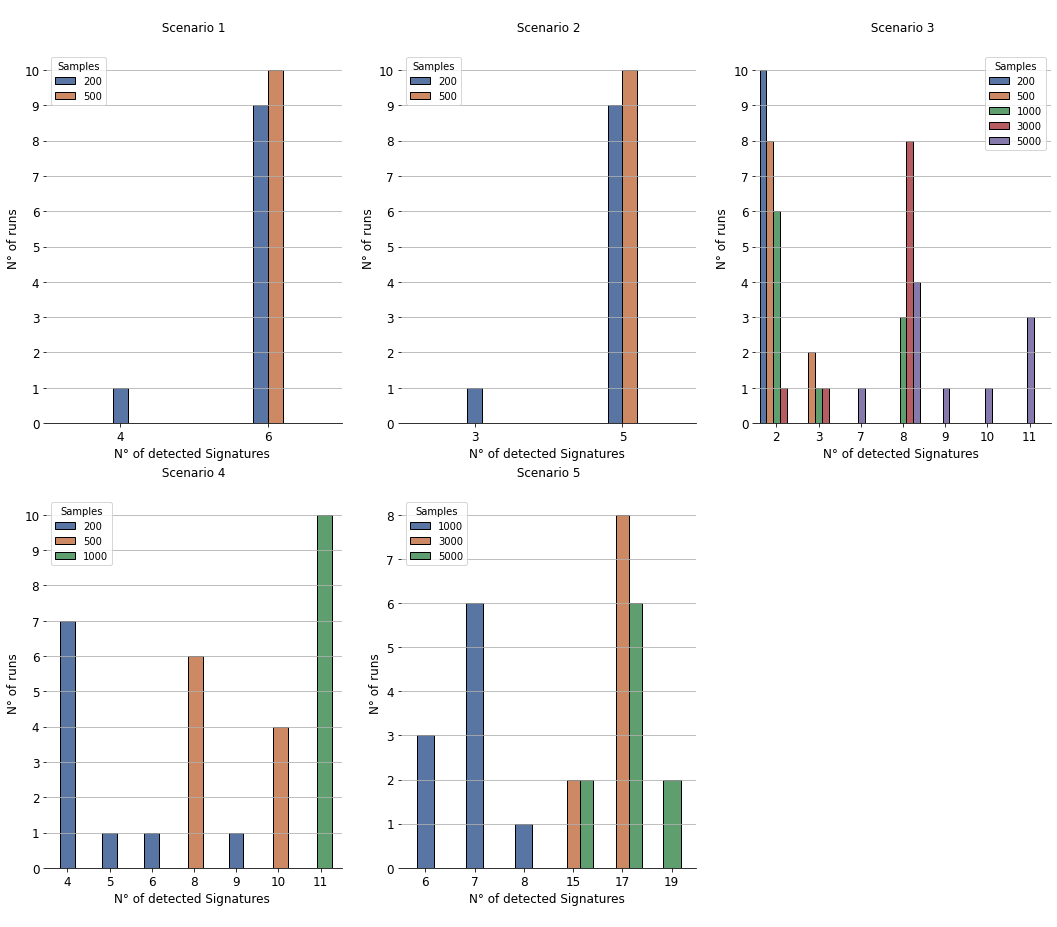

In [15]:
plot_extraction()